# Radio Map 补全任务 - 空间频域混合方法

## 方法说明
本方法不参考任何论文，基于Radio Map的物理特性自主设计：
- **空间上下文感知**：利用多尺度空间特征捕获信号传播模式
- **频域分析**：通过FFT分析频域特征，适合处理周期性信号模式
- **渐进式修复**：从粗粒度到细粒度逐步完善预测
- **物理约束**：考虑信号传播的物理规律（距离衰减、障碍物遮挡）

## 1. 环境配置和导入库

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.fft as fft

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda
GPU: NVIDIA GeForce RTX 5090
Memory: 31.36 GB


## 2. 数据路径配置

In [2]:
TRAIN_PATH = os.path.join('Data', 'train')
TEST_PATH = os.path.join('Data', 'test(student)')
MASK_PATH = os.path.join(TEST_PATH, 'mask.csv')

OUTPUT_PATH = 'output_spatial_frequency'
MODEL_PATH = 'models_spatial_frequency'
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

print(f"训练数据路径: {TRAIN_PATH}")
print(f"测试数据路径: {TEST_PATH}")
print(f"遮罩文件路径: {MASK_PATH}")

训练数据路径: Data/train
测试数据路径: Data/test(student)
遮罩文件路径: Data/test(student)/mask.csv


## 3. 数据加载和预处理

In [3]:
def load_masks(mask_path):
    masks = []
    with open(mask_path, 'r') as f:
        for line in f:
            coords = line.strip().split(',')
            if len(coords) == 4:
                masks.append([int(x) for x in coords])
    return masks

def apply_masks_to_image(img, masks, fill_value=0.5):
    img_masked = img.copy()
    mask_binary = np.ones_like(img)
    
    for mask in masks:
        x1, y1, x2, y2 = mask
        img_masked[y1:y2+1, x1:x2+1] = fill_value
        mask_binary[y1:y2+1, x1:x2+1] = 0
    
    return img_masked, mask_binary

class RadioMapDataset(Dataset):
    def __init__(self, data_path, masks=None, mode='train', transform=None, augment=False):
        self.data_path = data_path
        self.masks = masks
        self.mode = mode
        self.transform = transform
        self.augment = augment and mode == 'train'
        
        self.image_files = sorted([f for f in os.listdir(data_path) if f.endswith('.png')])
        
        if mode == 'train':
            n_train = int(len(self.image_files) * 0.9)
            self.image_files = self.image_files[:n_train]
        elif mode == 'val':
            n_train = int(len(self.image_files) * 0.9)
            self.image_files = self.image_files[n_train:]
            
        print(f"{mode} dataset size: {len(self.image_files)}")
    
    def __len__(self):
        return len(self.image_files)
    
    def augment_image(self, img):
        """数据增强：添加轻微噪声和亮度变化"""
        if random.random() > 0.5:
            noise = np.random.normal(0, 0.01, img.shape)
            img = np.clip(img + noise, 0, 1)
        if random.random() > 0.5:
            brightness = random.uniform(0.95, 1.05)
            img = np.clip(img * brightness, 0, 1)
        return img
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, self.image_files[idx])
        img = Image.open(img_path).convert('L')
        img = np.array(img, dtype=np.float32) / 255.0
        
        if self.augment:
            img = self.augment_image(img)
        
        if self.mode in ['train', 'val']:
            if self.masks:
                img_masked, mask_binary = apply_masks_to_image(img, self.masks, fill_value=0.5)
            else:
                img_masked, mask_binary = self.generate_random_masks(img)
            
            # 确保返回float32类型
            img_tensor = torch.from_numpy(img.astype(np.float32)).unsqueeze(0)
            img_masked_tensor = torch.from_numpy(img_masked.astype(np.float32)).unsqueeze(0)
            mask_tensor = torch.from_numpy(mask_binary.astype(np.float32)).unsqueeze(0)
            
            return {
                'input': img_masked_tensor,
                'target': img_tensor,
                'mask': mask_tensor,
                'filename': self.image_files[idx]
            }
        else:
            if self.masks:
                img_masked, mask_binary = apply_masks_to_image(img, self.masks, fill_value=0.5)
            else:
                img_masked = img
                mask_binary = np.ones_like(img)
            
            # 确保返回float32类型
            img_tensor = torch.from_numpy(img.astype(np.float32)).unsqueeze(0)
            img_masked_tensor = torch.from_numpy(img_masked.astype(np.float32)).unsqueeze(0)
            mask_tensor = torch.from_numpy(mask_binary.astype(np.float32)).unsqueeze(0)
            
            return {
                'input': img_masked_tensor,
                'original': img_tensor,
                'mask': mask_tensor,
                'filename': self.image_files[idx]
            }
    
    def generate_random_masks(self, img):
        h, w = img.shape
        img_masked = img.copy()
        mask_binary = np.ones_like(img)
        
        n_masks = random.randint(10, 20)
        for _ in range(n_masks):
            mask_h = random.randint(5, 15)
            mask_w = random.randint(5, 15)
            x = random.randint(0, w - mask_w)
            y = random.randint(0, h - mask_h)
            
            img_masked[y:y+mask_h, x:x+mask_w] = 0.5
            mask_binary[y:y+mask_h, x:x+mask_w] = 0
        
        return img_masked, mask_binary

masks = load_masks(MASK_PATH)
print(f"加载了 {len(masks)} 个遮罩")
print(f"方法特点：空间频域混合，渐进式修复")

加载了 144 个遮罩
方法特点：空间频域混合，渐进式修复


## 4. 自主设计的网络架构

In [4]:
class SpatialContextBlock(nn.Module):
    """空间上下文感知模块"""
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7]):
        super(SpatialContextBlock, self).__init__()
        self.branches = nn.ModuleList()
        
        for k in kernel_sizes:
            padding = k // 2
            self.branches.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels // len(kernel_sizes), 
                             kernel_size=k, padding=padding),
                    nn.BatchNorm2d(out_channels // len(kernel_sizes)),
                    nn.ReLU(inplace=True)
                )
            )
        
        self.fusion = nn.Sequential(
            nn.Conv2d(out_channels // len(kernel_sizes) * len(kernel_sizes), 
                     out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        features = []
        for branch in self.branches:
            features.append(branch(x))
        
        multi_scale = torch.cat(features, dim=1)
        return self.fusion(multi_scale)


class FrequencyDomainModule(nn.Module):
    """频域分析模块 - 利用FFT处理周期性信号模式"""
    def __init__(self, channels):
        super(FrequencyDomainModule, self).__init__()
        self.channels = channels
        
        # 频域特征提取
        self.freq_conv = nn.Sequential(
            nn.Conv2d(channels * 2, channels, kernel_size=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        
        # 空间域和频域融合
        self.fusion = nn.Sequential(
            nn.Conv2d(channels * 2, channels, kernel_size=1),
            nn.BatchNorm2d(channels),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # 转换到频域
        freq = torch.fft.fft2(x, norm='ortho')
        freq_real = freq.real
        freq_imag = freq.imag
        
        # 频域特征提取
        freq_features = torch.cat([freq_real, freq_imag], dim=1)
        freq_features = self.freq_conv(freq_features)
        
        # 融合门控
        gate = self.fusion(torch.cat([x, freq_features], dim=1))
        
        # 加权融合
        output = x * gate + freq_features * (1 - gate)
        
        return output


class ProgressiveRefinementBlock(nn.Module):
    """渐进式细化模块"""
    def __init__(self, channels, scales=[4, 2, 1]):
        super(ProgressiveRefinementBlock, self).__init__()
        self.scales = scales
        self.refiners = nn.ModuleList()
        
        for scale in scales:
            self.refiners.append(
                nn.Sequential(
                    nn.Conv2d(channels, channels, kernel_size=3, padding=1),
                    nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(channels, channels, kernel_size=3, padding=1),
                    nn.BatchNorm2d(channels)
                )
            )
        
        self.attention = nn.Sequential(
            nn.Conv2d(channels * len(scales), channels, kernel_size=1),
            nn.BatchNorm2d(channels),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h, w = x.shape[2:]
        multi_scale_features = []
        
        for scale, refiner in zip(self.scales, self.refiners):
            if scale > 1:
                # 下采样处理
                x_scaled = F.interpolate(x, scale_factor=1/scale, mode='bilinear', align_corners=False)
                refined = refiner(x_scaled)
                # 上采样回原尺寸
                refined = F.interpolate(refined, size=(h, w), mode='bilinear', align_corners=False)
            else:
                refined = refiner(x)
            
            multi_scale_features.append(refined)
        
        # 自适应融合
        concat_features = torch.cat(multi_scale_features, dim=1)
        attention_weights = self.attention(concat_features)
        
        # 加权求和
        output = sum([f * attention_weights for f in multi_scale_features])
        
        return output + x  # 残差连接


class PhysicalConstraintModule(nn.Module):
    """物理约束模块 - 确保信号传播的物理特性"""
    def __init__(self, channels):
        super(PhysicalConstraintModule, self).__init__()
        
        # 学习信号衰减模式
        self.decay_pattern = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(channels),
            nn.Sigmoid()
        )
        
        # 平滑性约束
        self.smoothness = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.Tanh()
        )
    
    def forward(self, x, mask):
        # 应用物理衰减模式
        decay_weights = self.decay_pattern(x)
        x_decayed = x * decay_weights
        
        # 平滑性处理（主要针对边界）
        smoothness_term = self.smoothness(x_decayed)
        
        # 只在mask区域应用约束
        output = x_decayed + smoothness_term * (1 - mask)
        
        return output


class SpatialFrequencyNetwork(nn.Module):
    """主网络：空间频域混合网络"""
    def __init__(self, in_channels=2, out_channels=1, base_channels=64):
        super(SpatialFrequencyNetwork, self).__init__()
        
        # 输入编码
        self.input_encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=7, padding=3),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True)
        )
        
        # 空间上下文编码器
        self.spatial_encoder = nn.Sequential(
            SpatialContextBlock(base_channels, base_channels * 2),
            nn.MaxPool2d(2),
            SpatialContextBlock(base_channels * 2, base_channels * 4),
            nn.MaxPool2d(2),
            SpatialContextBlock(base_channels * 4, base_channels * 8)
        )
        
        # 频域分析
        self.freq_module = FrequencyDomainModule(base_channels * 8)
        
        # 瓶颈层
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels * 8, base_channels * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 8),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 8, base_channels * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 8),
            nn.ReLU(inplace=True)
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 
                              kernel_size=2, stride=2),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(base_channels * 4, base_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 
                              kernel_size=2, stride=2),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(base_channels * 2, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True)
        )
        
        # 渐进式细化
        self.progressive_refinement = ProgressiveRefinementBlock(base_channels)
        
        # 物理约束
        self.physical_constraint = PhysicalConstraintModule(base_channels)
        
        # 输出层
        self.output_conv = nn.Sequential(
            nn.Conv2d(base_channels, base_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels // 2, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x, mask):
        # 输入编码
        features = self.input_encoder(x)
        
        # 空间编码
        encoded = self.spatial_encoder(features)
        
        # 频域分析
        freq_features = self.freq_module(encoded)
        
        # 瓶颈处理
        bottleneck_features = self.bottleneck(freq_features)
        
        # 解码
        decoded = self.decoder(bottleneck_features)
        
        # 渐进式细化
        refined = self.progressive_refinement(decoded)
        
        # 物理约束
        constrained = self.physical_constraint(refined, mask)
        
        # 输出
        output = self.output_conv(constrained)
        
        return output


def test_model():
    model = SpatialFrequencyNetwork(in_channels=2, out_channels=1)
    model = model.to(device)
    
    test_input = torch.randn(2, 2, 256, 256).to(device)
    test_mask = torch.ones(2, 1, 256, 256).to(device)
    
    with torch.no_grad():
        output = model(test_input, test_mask)
    
    print(f"输入尺寸: {test_input.shape}")
    print(f"输出尺寸: {output.shape}")
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"总参数量: {total_params:,}")
    print(f"可训练参数量: {trainable_params:,}")

test_model()

输入尺寸: torch.Size([2, 2, 256, 256])
输出尺寸: torch.Size([2, 1, 256, 256])
总参数量: 15,043,442
可训练参数量: 15,043,442


## 5. 自定义损失函数

In [5]:
class RadioMapLoss(nn.Module):
    """针对Radio Map特性设计的损失函数"""
    def __init__(self, mse_weight=1.0, freq_weight=0.1, smooth_weight=0.05, edge_weight=0.1):
        super(RadioMapLoss, self).__init__()
        self.mse_weight = mse_weight
        self.freq_weight = freq_weight
        self.smooth_weight = smooth_weight
        self.edge_weight = edge_weight
        
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        
        # 边缘检测核
        sobel_x = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], dtype=torch.float32)
        sobel_y = torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], dtype=torch.float32)
        self.register_buffer('sobel_x', sobel_x)
        self.register_buffer('sobel_y', sobel_y)
        
        self.losses = {}
    
    def frequency_loss(self, pred, target):
        """频域损失 - 保持频谱一致性"""
        pred_fft = torch.fft.fft2(pred, norm='ortho')
        target_fft = torch.fft.fft2(target, norm='ortho')
        
        # 幅度谱损失
        pred_mag = torch.abs(pred_fft)
        target_mag = torch.abs(target_fft)
        mag_loss = self.l1_loss(pred_mag, target_mag)
        
        # 相位谱损失（较小权重）
        pred_phase = torch.angle(pred_fft)
        target_phase = torch.angle(target_fft)
        phase_loss = self.l1_loss(pred_phase, target_phase) * 0.1
        
        return mag_loss + phase_loss
    
    def smoothness_loss(self, pred):
        """平滑度损失 - 确保信号连续性"""
        dx = pred[:, :, :, 1:] - pred[:, :, :, :-1]
        dy = pred[:, :, 1:, :] - pred[:, :, :-1, :]
        
        dx2 = dx[:, :, :, 1:] - dx[:, :, :, :-1]
        dy2 = dy[:, :, 1:, :] - dy[:, :, :-1, :]
        
        return (torch.mean(torch.abs(dx2)) + torch.mean(torch.abs(dy2))) / 2.0
    
    def edge_preserving_loss(self, pred, target):
        """边缘保持损失 - 保持建筑物边界清晰"""
        # Sobel边缘检测
        pred_edge_x = F.conv2d(pred, self.sobel_x, padding=1)
        pred_edge_y = F.conv2d(pred, self.sobel_y, padding=1)
        target_edge_x = F.conv2d(target, self.sobel_x, padding=1)
        target_edge_y = F.conv2d(target, self.sobel_y, padding=1)
        
        pred_edge = torch.sqrt(pred_edge_x**2 + pred_edge_y**2 + 1e-6)
        target_edge = torch.sqrt(target_edge_x**2 + target_edge_y**2 + 1e-6)
        
        return self.l1_loss(pred_edge, target_edge)
    
    def forward(self, pred, target, mask=None):
        # 主要损失 - MSE（只在mask区域）
        if mask is not None:
            mask_region = (1 - mask)
            mse = self.mse_loss(pred * mask_region, target * mask_region)
        else:
            mse = self.mse_loss(pred, target)
        
        # 频域损失
        freq = self.frequency_loss(pred, target)
        
        # 平滑度损失
        smooth = self.smoothness_loss(pred)
        
        # 边缘保持损失
        edge = self.edge_preserving_loss(pred, target)
        
        # 记录各项损失
        self.losses = {
            'mse': mse.item(),
            'freq': freq.item(),
            'smooth': smooth.item(),
            'edge': edge.item()
        }
        
        # 总损失
        total_loss = (self.mse_weight * mse + 
                     self.freq_weight * freq + 
                     self.smooth_weight * smooth + 
                     self.edge_weight * edge)
        
        return total_loss


def calculate_nmse(pred, target, mask=None):
    """计算NMSE（按PDF公式）"""
    mse = torch.mean((pred - target) ** 2)
    return mse.item()

## 6. 训练配置

In [6]:
class Config:
    batch_size = 24
    num_workers = 24
    
    base_channels = 64
    
    epochs = 50  
    learning_rate = 0.001
    weight_decay = 1e-5
    
    # 损失权重
    mse_weight = 1.0
    freq_weight = 0.1
    smooth_weight = 0.05
    edge_weight = 0.1
    
    # 其他
    save_interval = 10  # 每10个epoch保存一次
    log_interval = 20
    val_interval = 1
    
    # 数据增强
    augment = True
    
    # 学习率调度
    T_0 = 10  # 重启周期
    T_mult = 2
    eta_min = 1e-6

config = Config()

# 数据加载器
train_dataset = RadioMapDataset(TRAIN_PATH, masks=masks, mode='train', augment=config.augment)
val_dataset = RadioMapDataset(TRAIN_PATH, masks=masks, mode='val')
test_dataset = RadioMapDataset(TEST_PATH, masks=masks, mode='test')

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, 
                         shuffle=True, num_workers=config.num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, 
                       shuffle=False, num_workers=config.num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, 
                        shuffle=False, num_workers=config.num_workers)

print(f"训练批次数: {len(train_loader)}")
print(f"验证批次数: {len(val_loader)}")
print(f"测试批次数: {len(test_loader)}")

train dataset size: 44163
val dataset size: 4907
test dataset size: 7010
训练批次数: 1841
验证批次数: 205
测试批次数: 7010


## 7. 训练和验证函数

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device, epoch, config):
    model.train()
    running_loss = 0.0
    running_nmse = 0.0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}/{config.epochs}')
    
    for batch_idx, batch in enumerate(progress_bar):
        input_img = batch['input'].to(device)
        target_img = batch['target'].to(device)
        mask = batch['mask'].to(device)
        
        model_input = torch.cat([input_img, mask], dim=1)
        
        optimizer.zero_grad()
        output = model(model_input, mask)
        
        # 融合输出
        fused_output = input_img * mask + output * (1 - mask)
        
        loss = criterion(fused_output, target_img, mask)
        
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        nmse = calculate_nmse(fused_output, target_img)
        running_nmse += nmse
        
        if batch_idx % config.log_interval == 0:
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4g}',
                'NMSE': f'{nmse:.4g}',
                'MSE': f'{criterion.losses.get("mse", 0):.4g}',
                'Freq': f'{criterion.losses.get("freq", 0):.4g}',
                'Smooth': f'{criterion.losses.get("smooth", 0):.4g}',
                'Edge': f'{criterion.losses.get("edge", 0):.4g}'
            })
    
    avg_loss = running_loss / len(dataloader)
    avg_nmse = running_nmse / len(dataloader)
    
    return avg_loss, avg_nmse


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_nmse = 0.0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validation'):
            input_img = batch['input'].to(device)
            target_img = batch['target'].to(device)
            mask = batch['mask'].to(device)
            
            model_input = torch.cat([input_img, mask], dim=1)
            
            output = model(model_input, mask)
            
            fused_output = input_img * mask + output * (1 - mask)
            
            loss = criterion(fused_output, target_img, mask)
            nmse = calculate_nmse(fused_output, target_img)
            
            running_loss += loss.item()
            running_nmse += nmse
    
    avg_loss = running_loss / len(dataloader)
    avg_nmse = running_nmse / len(dataloader)
    
    return avg_loss, avg_nmse


def visualize_results(model, dataloader, device, num_samples=4):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3*num_samples))
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
            
            input_img = batch['input'].to(device)
            target_img = batch['target'].to(device)
            mask = batch['mask'].to(device)
            
            model_input = torch.cat([input_img, mask], dim=1)
            
            output = model(model_input, mask)
            
            fused_output = input_img * mask + output * (1 - mask)
            
            input_np = input_img[0, 0].cpu().numpy()
            target_np = target_img[0, 0].cpu().numpy()
            output_np = fused_output[0, 0].cpu().numpy()
            mask_np = mask[0, 0].cpu().numpy()
            
            axes[i, 0].imshow(input_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 0].set_title('Input (with mask)')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(target_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 1].set_title('Target')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(output_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
            
            diff = np.abs(target_np - output_np)
            axes[i, 3].imshow(diff, cmap='hot', vmin=0, vmax=0.5)
            axes[i, 3].set_title(f'Difference (NMSE: {calculate_nmse(fused_output, target_img):.4g})')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

## 8. 训练主循环

开始训练（空间频域混合方法）...
特点: 空间上下文感知 + 频域分析 + 渐进式修复 + 物理约束

Learning Rate: 1.00e-03


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.64it/s]



Epoch 1: Train Loss: 0.01307, Train NMSE: 0.000608
         Val Loss: 0.01304, Val NMSE: 0.0005237
保存最佳模型 (NMSE: 0.0005237)

Learning Rate: 9.76e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.64it/s]



Epoch 2: Train Loss: 0.007843, Train NMSE: 0.0001252
         Val Loss: 0.01343, Val NMSE: 0.0005187
保存最佳模型 (NMSE: 0.0005187)

Learning Rate: 9.05e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.67it/s]



Epoch 3: Train Loss: 0.006426, Train NMSE: 7.745e-05
         Val Loss: 0.01308, Val NMSE: 0.0004945
保存最佳模型 (NMSE: 0.0004945)

Learning Rate: 7.94e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.63it/s]



Epoch 4: Train Loss: 0.005847, Train NMSE: 6.069e-05
         Val Loss: 0.01284, Val NMSE: 0.0004805
保存最佳模型 (NMSE: 0.0004805)

Learning Rate: 6.55e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.62it/s]



Epoch 5: Train Loss: 0.005483, Train NMSE: 5.013e-05
         Val Loss: 0.01274, Val NMSE: 0.0004642
保存最佳模型 (NMSE: 0.0004642)

Learning Rate: 5.01e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.63it/s]



Epoch 6: Train Loss: 0.005196, Train NMSE: 4.216e-05
         Val Loss: 0.01287, Val NMSE: 0.0004849

Learning Rate: 3.46e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.63it/s]



Epoch 7: Train Loss: 0.004959, Train NMSE: 3.595e-05
         Val Loss: 0.0128, Val NMSE: 0.0004765

Learning Rate: 2.07e-04


Validation: 100%|██████████| 205/205 [00:27<00:00,  7.56it/s]



Epoch 8: Train Loss: 0.004776, Train NMSE: 3.146e-05
         Val Loss: 0.01283, Val NMSE: 0.00048

Learning Rate: 9.64e-05


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.60it/s]



Epoch 9: Train Loss: 0.004671, Train NMSE: 2.862e-05
         Val Loss: 0.01259, Val NMSE: 0.0004559
保存最佳模型 (NMSE: 0.0004559)

Learning Rate: 2.54e-05


Validation: 100%|██████████| 205/205 [00:27<00:00,  7.58it/s]



Epoch 10: Train Loss: 0.004619, Train NMSE: 2.709e-05
         Val Loss: 0.01257, Val NMSE: 0.0004561


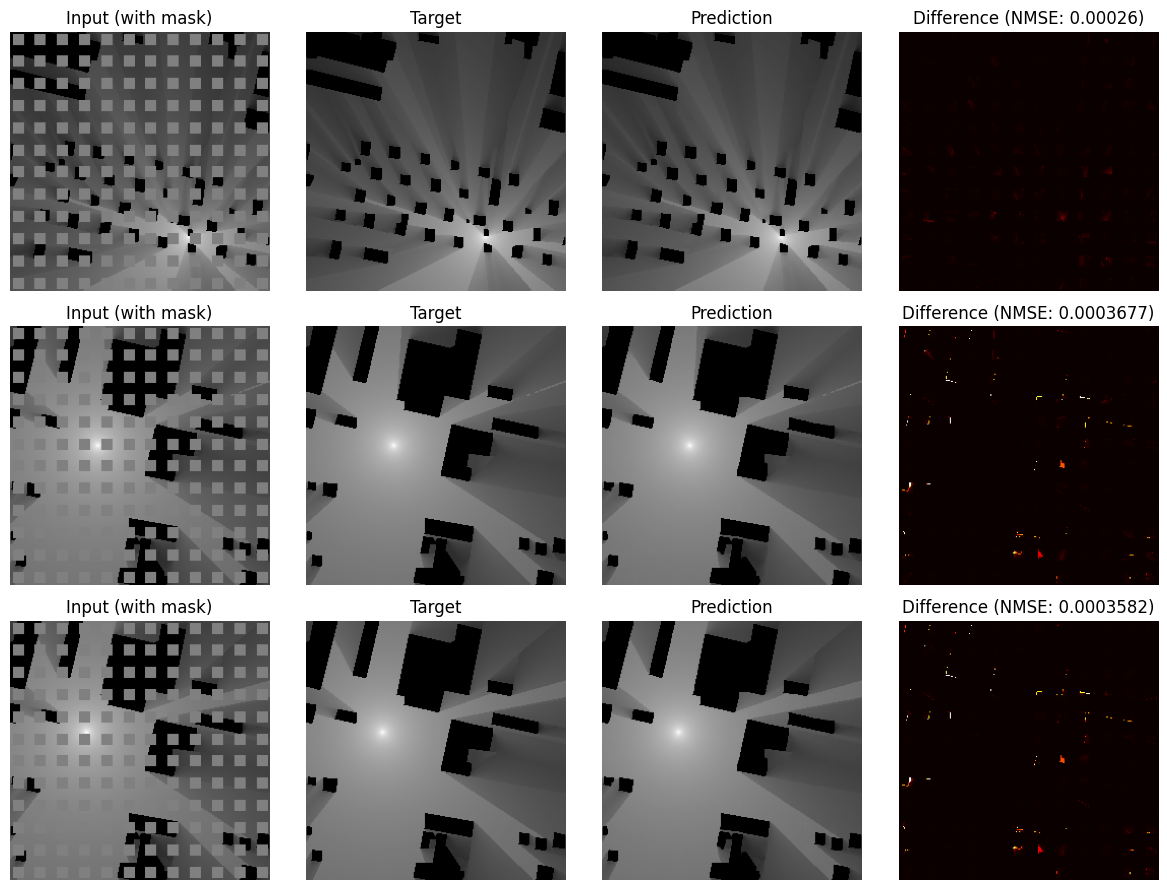


Learning Rate: 1.00e-03


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.66it/s]



Epoch 11: Train Loss: 0.005755, Train NMSE: 5.511e-05
         Val Loss: 0.01313, Val NMSE: 0.0005059

Learning Rate: 9.94e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.62it/s]



Epoch 12: Train Loss: 0.005215, Train NMSE: 4.167e-05
         Val Loss: 0.01295, Val NMSE: 0.0004947

Learning Rate: 9.76e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.64it/s]



Epoch 13: Train Loss: 0.005072, Train NMSE: 3.786e-05
         Val Loss: 0.01274, Val NMSE: 0.0004627

Learning Rate: 9.46e-04


Epoch 14/50:  57%|█████▋    | 1041/1841 [07:44<05:56,  2.24it/s, Loss=0.005653, NMSE=4.355e-05, MSE=4.355e-05, Freq=0.03358, Smooth=0.02825, Edge=0.008386]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Validation: 100%|██████████| 205/205 [00:26<00:00,  7.61it/s]



Epoch 22: Train Loss: 0.004406, Train NMSE: 2.566e-05
         Val Loss: 0.01259, Val NMSE: 0.0004675

Learning Rate: 3.46e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.62it/s]



Epoch 23: Train Loss: 0.004363, Train NMSE: 2.492e-05
         Val Loss: 0.01253, Val NMSE: 0.0004618

Learning Rate: 2.74e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.65it/s]



Epoch 24: Train Loss: 0.004305, Train NMSE: 2.387e-05
         Val Loss: 0.01248, Val NMSE: 0.0004592

Learning Rate: 2.07e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.67it/s]



Epoch 25: Train Loss: 0.004257, Train NMSE: 2.318e-05
         Val Loss: 0.01256, Val NMSE: 0.0004667

Learning Rate: 1.47e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.64it/s]



Epoch 26: Train Loss: 0.004237, Train NMSE: 2.266e-05
         Val Loss: 0.01248, Val NMSE: 0.000461

Learning Rate: 9.64e-05


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.60it/s]



Epoch 27: Train Loss: 0.004225, Train NMSE: 2.229e-05
         Val Loss: 0.01245, Val NMSE: 0.0004578

Learning Rate: 5.54e-05


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.65it/s]



Epoch 28: Train Loss: 0.004192, Train NMSE: 2.183e-05
         Val Loss: 0.01245, Val NMSE: 0.0004538
保存最佳模型 (NMSE: 0.0004538)

Learning Rate: 2.54e-05


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.65it/s]



Epoch 29: Train Loss: 0.004174, Train NMSE: 2.158e-05
         Val Loss: 0.01245, Val NMSE: 0.0004569

Learning Rate: 7.15e-06


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.64it/s]



Epoch 30: Train Loss: 0.004181, Train NMSE: 2.157e-05
         Val Loss: 0.01245, Val NMSE: 0.0004575


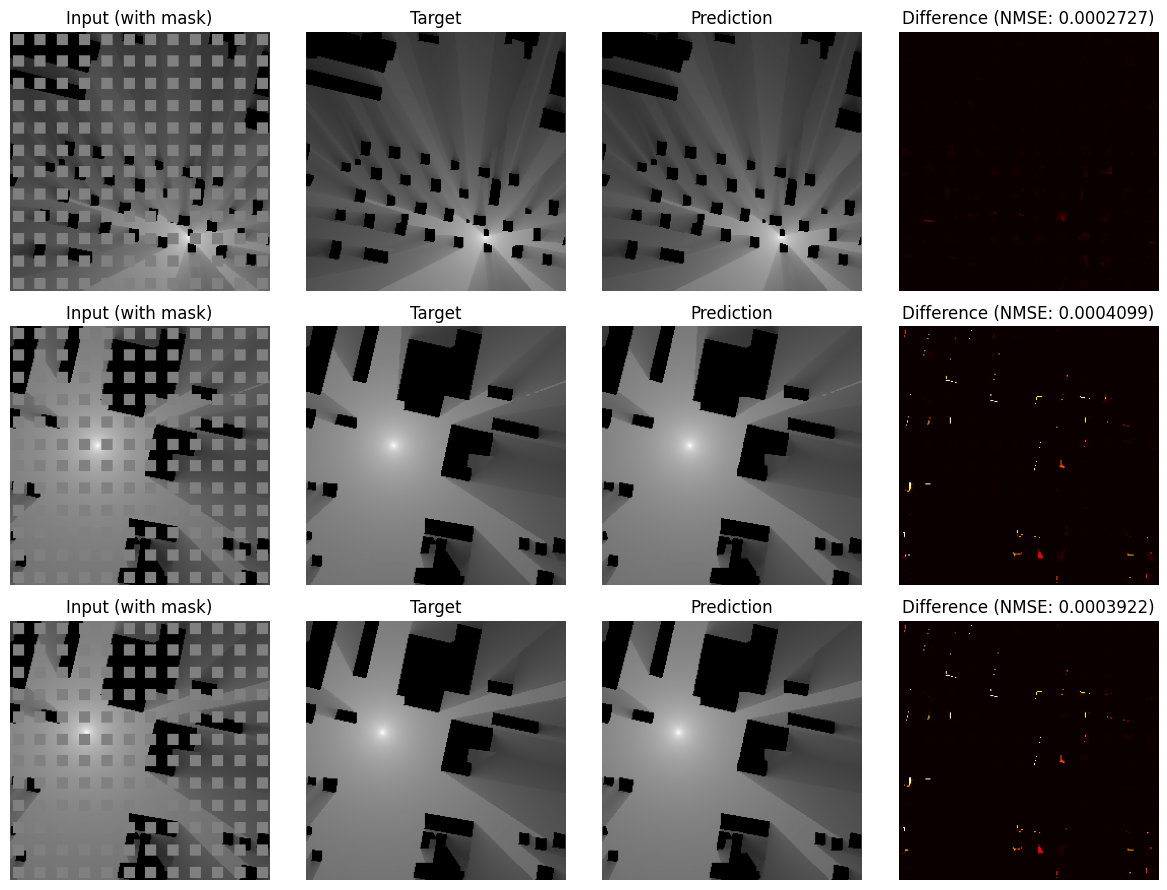


Learning Rate: 1.00e-03


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.65it/s]



Epoch 31: Train Loss: 0.004788, Train NMSE: 3.291e-05
         Val Loss: 0.01259, Val NMSE: 0.000474

Learning Rate: 9.98e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.61it/s]



Epoch 32: Train Loss: 0.004569, Train NMSE: 2.9e-05
         Val Loss: 0.01274, Val NMSE: 0.0004779

Learning Rate: 9.94e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.60it/s]



Epoch 33: Train Loss: 0.004562, Train NMSE: 2.84e-05
         Val Loss: 0.01259, Val NMSE: 0.0004727

Learning Rate: 9.86e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.61it/s]



Epoch 34: Train Loss: 0.004497, Train NMSE: 2.765e-05
         Val Loss: 0.01299, Val NMSE: 0.0004936

Learning Rate: 9.76e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.61it/s]



Epoch 35: Train Loss: 0.004474, Train NMSE: 2.7e-05
         Val Loss: 0.01259, Val NMSE: 0.00047

Learning Rate: 9.62e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.65it/s]



Epoch 36: Train Loss: 0.00445, Train NMSE: 2.669e-05
         Val Loss: 0.01268, Val NMSE: 0.0004783

Learning Rate: 9.46e-04


Validation: 100%|██████████| 205/205 [00:27<00:00,  7.56it/s]



Epoch 37: Train Loss: 0.004443, Train NMSE: 2.652e-05
         Val Loss: 0.01247, Val NMSE: 0.000461

Learning Rate: 9.26e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.65it/s]



Epoch 38: Train Loss: 0.004399, Train NMSE: 2.553e-05
         Val Loss: 0.01258, Val NMSE: 0.0004705

Learning Rate: 9.05e-04


Validation: 100%|██████████| 205/205 [00:27<00:00,  7.58it/s]



Epoch 39: Train Loss: 0.004388, Train NMSE: 2.559e-05
         Val Loss: 0.01253, Val NMSE: 0.0004666

Learning Rate: 8.80e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.65it/s]



Epoch 40: Train Loss: 0.004347, Train NMSE: 2.466e-05
         Val Loss: 0.01262, Val NMSE: 0.00048


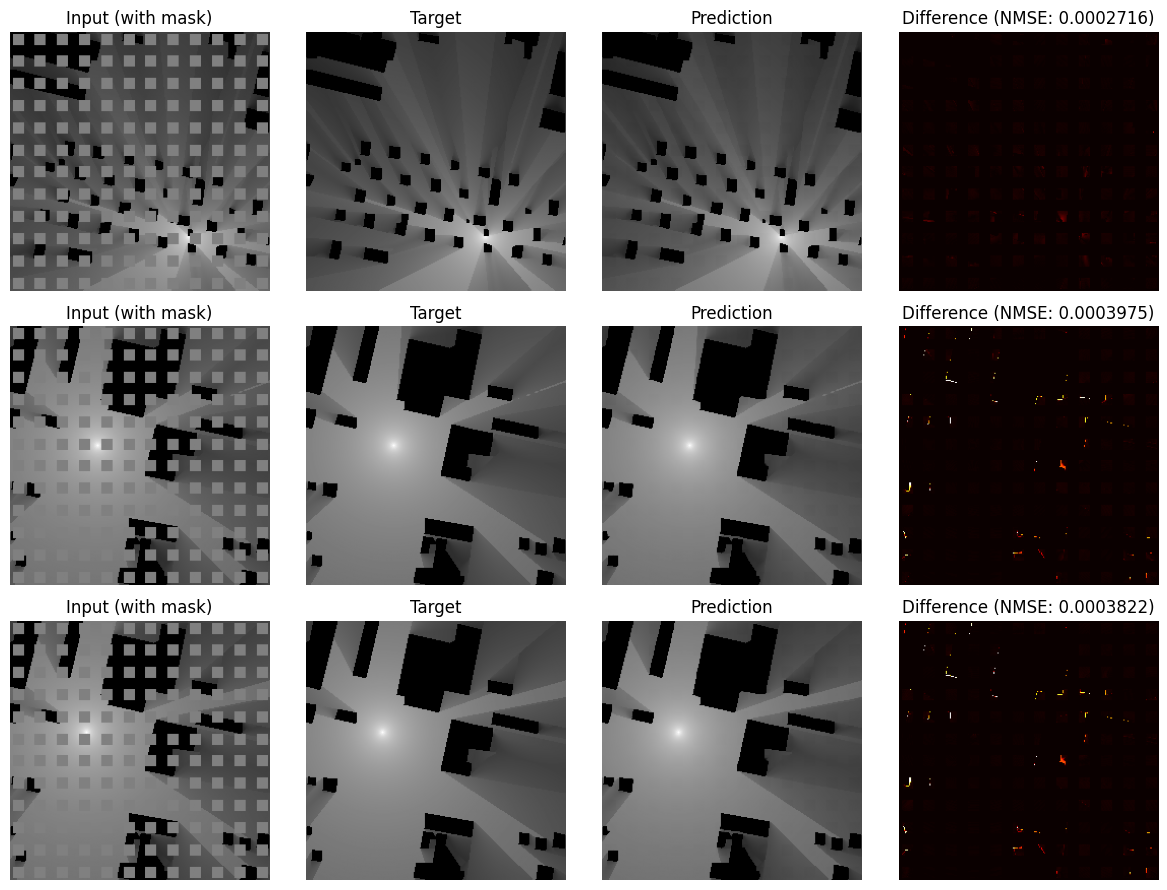


Learning Rate: 8.54e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.62it/s]



Epoch 41: Train Loss: 0.00434, Train NMSE: 2.458e-05
         Val Loss: 0.01256, Val NMSE: 0.0004712

Learning Rate: 8.25e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.65it/s]



Epoch 42: Train Loss: 0.004343, Train NMSE: 2.468e-05
         Val Loss: 0.01271, Val NMSE: 0.0004901

Learning Rate: 7.94e-04


Validation: 100%|██████████| 205/205 [00:27<00:00,  7.53it/s]



Epoch 43: Train Loss: 0.004293, Train NMSE: 2.393e-05
         Val Loss: 0.01255, Val NMSE: 0.0004679

Learning Rate: 7.61e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.65it/s]



Epoch 44: Train Loss: 0.004281, Train NMSE: 2.368e-05
         Val Loss: 0.01253, Val NMSE: 0.000473

Learning Rate: 7.27e-04


Validation: 100%|██████████| 205/205 [00:27<00:00,  7.56it/s]



Epoch 45: Train Loss: 0.004267, Train NMSE: 2.321e-05
         Val Loss: 0.01261, Val NMSE: 0.0004845

Learning Rate: 6.92e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.68it/s]



Epoch 46: Train Loss: 0.004242, Train NMSE: 2.271e-05
         Val Loss: 0.01256, Val NMSE: 0.0004705

Learning Rate: 6.55e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.63it/s]



Epoch 47: Train Loss: 0.004225, Train NMSE: 2.249e-05
         Val Loss: 0.01264, Val NMSE: 0.0004763

Learning Rate: 6.17e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.63it/s]



Epoch 48: Train Loss: 0.004219, Train NMSE: 2.24e-05
         Val Loss: 0.0129, Val NMSE: 0.0004953

Learning Rate: 5.79e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.68it/s]



Epoch 49: Train Loss: 0.004198, Train NMSE: 2.206e-05
         Val Loss: 0.01256, Val NMSE: 0.0004681

Learning Rate: 5.40e-04


Validation: 100%|██████████| 205/205 [00:26<00:00,  7.63it/s]



Epoch 50: Train Loss: 0.004161, Train NMSE: 2.15e-05
         Val Loss: 0.01278, Val NMSE: 0.0004923


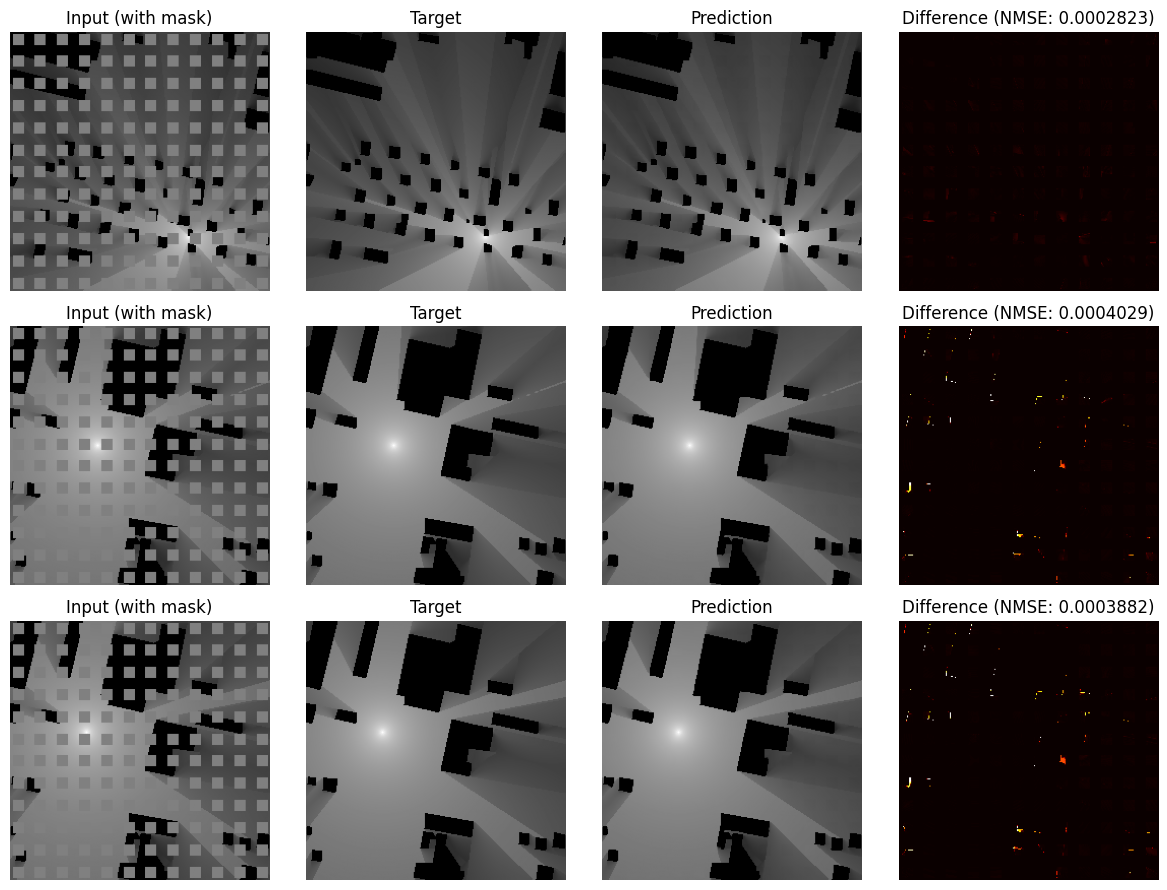


训练完成! 最佳模型: Epoch 28, NMSE: 0.0004538


In [8]:
# 初始化模型
model = SpatialFrequencyNetwork(
    in_channels=2,
    out_channels=1,
    base_channels=config.base_channels
)
model = model.to(device)

# 损失函数
criterion = RadioMapLoss(
    mse_weight=config.mse_weight,
    freq_weight=config.freq_weight,
    smooth_weight=config.smooth_weight,
    edge_weight=config.edge_weight
)
criterion = criterion.to(device)

# 优化器
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

# 学习率调度器 - Cosine Annealing with Warm Restarts
scheduler = CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=config.T_0, 
    T_mult=config.T_mult,
    eta_min=config.eta_min
)

# 训练历史
history = {
    'train_loss': [],
    'train_nmse': [],
    'val_loss': [],
    'val_nmse': [],
    'lr': []
}

best_val_nmse = float('inf')
best_epoch = 0

print("开始训练（空间频域混合方法）...")
print(f"特点: 空间上下文感知 + 频域分析 + 渐进式修复 + 物理约束")

for epoch in range(1, config.epochs + 1):
    # 获取当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)
    print(f"\nLearning Rate: {current_lr:.2e}")
    
    # 训练
    train_loss, train_nmse = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch, config
    )
    
    history['train_loss'].append(train_loss)
    history['train_nmse'].append(train_nmse)
    
    # 更新学习率
    scheduler.step()
    
    # 验证
    if epoch % config.val_interval == 0:
        val_loss, val_nmse = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_nmse'].append(val_nmse)
        
        print(f"\nEpoch {epoch}: Train Loss: {train_loss:.4g}, Train NMSE: {train_nmse:.4g}")
        print(f"         Val Loss: {val_loss:.4g}, Val NMSE: {val_nmse:.4g}")
        
        # 保存最佳模型
        if val_nmse < best_val_nmse:
            best_val_nmse = val_nmse
            best_epoch = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_nmse': val_nmse,
            }, os.path.join(MODEL_PATH, 'best_model.pth'))
            print(f"保存最佳模型 (NMSE: {val_nmse:.4g})")
        
        # 可视化
        if epoch % 10 == 0:
            visualize_results(model, val_loader, device, num_samples=3)
    
    # 定期保存
    if epoch % config.save_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
        }, os.path.join(MODEL_PATH, f'checkpoint_epoch_{epoch}.pth'))

print(f"\n训练完成! 最佳模型: Epoch {best_epoch}, NMSE: {best_val_nmse:.4g}")

## 9. 绘制训练曲线

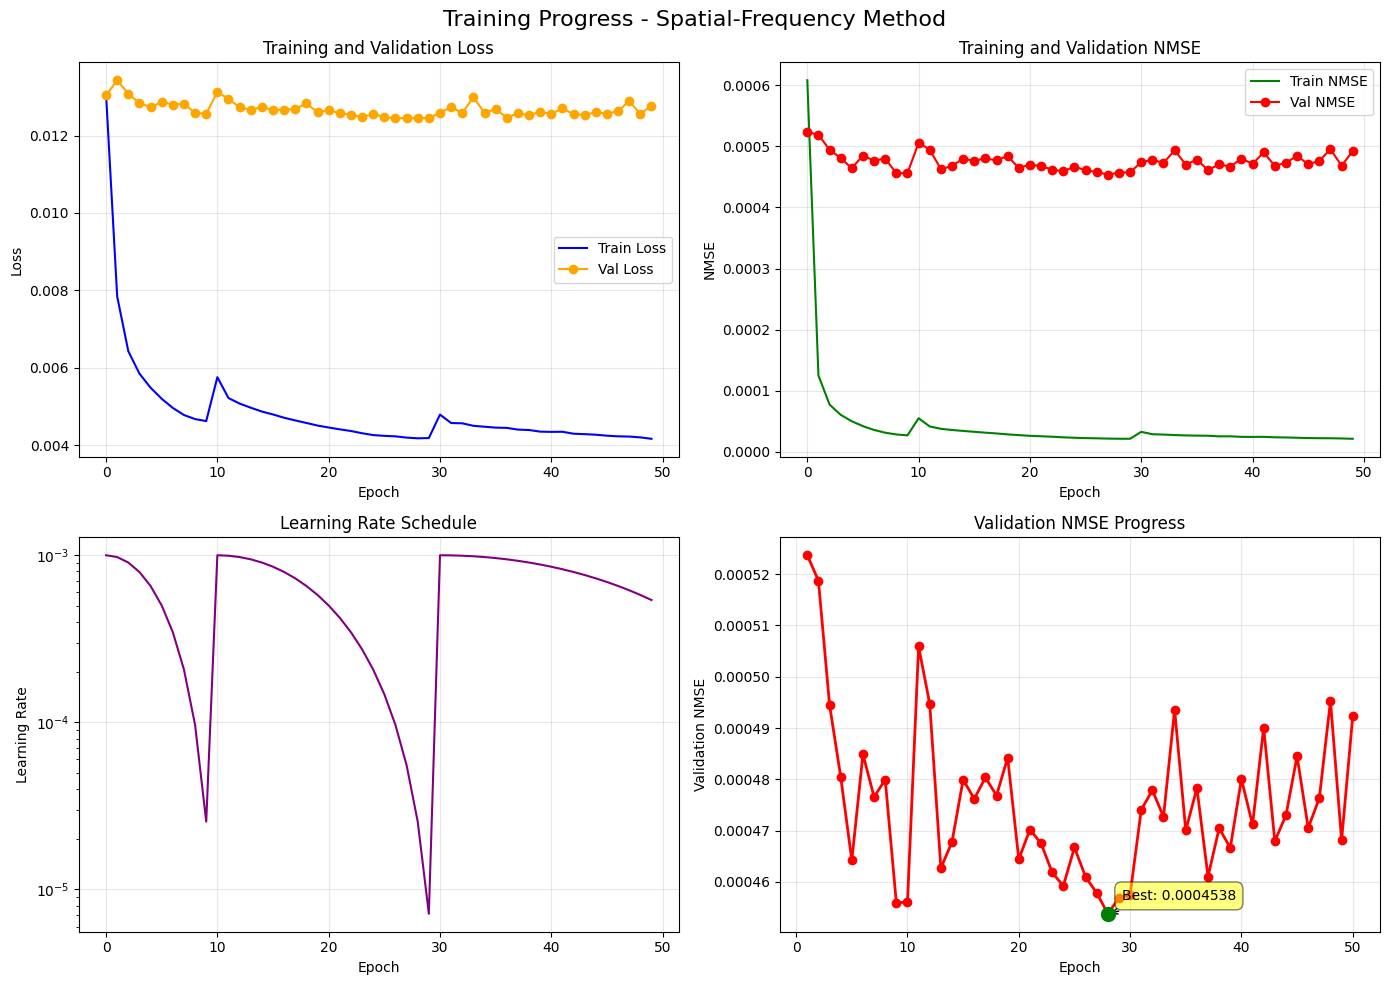

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 损失曲线
ax1.plot(history['train_loss'], label='Train Loss', color='blue')
if history['val_loss']:
    ax1.plot(np.arange(config.val_interval-1, len(history['train_loss']), config.val_interval), 
             history['val_loss'], label='Val Loss', marker='o', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# NMSE曲线
ax2.plot(history['train_nmse'], label='Train NMSE', color='green')
if history['val_nmse']:
    ax2.plot(np.arange(config.val_interval-1, len(history['train_nmse']), config.val_interval), 
             history['val_nmse'], label='Val NMSE', marker='o', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('NMSE')
ax2.set_title('Training and Validation NMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 学习率曲线
ax3.plot(history['lr'], color='purple')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# 验证NMSE详细视图
if history['val_nmse']:
    epochs_val = np.arange(config.val_interval, len(history['train_nmse'])+1, config.val_interval)
    ax4.plot(epochs_val, history['val_nmse'], marker='o', color='red', linewidth=2)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Validation NMSE')
    ax4.set_title('Validation NMSE Progress')
    ax4.grid(True, alpha=0.3)
    
    # 标记最佳点
    best_idx = np.argmin(history['val_nmse'])
    best_epoch_val = epochs_val[best_idx]
    best_nmse_val = history['val_nmse'][best_idx]
    ax4.scatter(best_epoch_val, best_nmse_val, color='green', s=100, zorder=5)
    ax4.annotate(f'Best: {best_nmse_val:.4g}', 
                xy=(best_epoch_val, best_nmse_val),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.suptitle('Training Progress - Spatial-Frequency Method', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'training_curves.png'), dpi=300)
plt.show()

## 10. 测试集预测

In [10]:
# 加载最佳模型
checkpoint = torch.load(os.path.join(MODEL_PATH, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"加载最佳模型 (Epoch {checkpoint['epoch']}, Val NMSE: {checkpoint['val_nmse']:.4g})")

# 预测测试集
model.eval()
predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_img = batch['input'].to(device)
        original_img = batch['original'].to(device)
        mask = batch['mask'].to(device)
        filename = batch['filename'][0]
        
        model_input = torch.cat([input_img, mask], dim=1)
        
        output = model(model_input, mask)
        
        # 融合输出
        final_output = original_img * mask + output * (1 - mask)
        
        # 保存预测结果
        output_np = (final_output[0, 0].cpu().numpy() * 255).astype(np.uint8)
        output_img = Image.fromarray(output_np, mode='L')
        
        output_path = os.path.join(OUTPUT_PATH, f'pred_{filename}')
        output_img.save(output_path)
        
        predictions.append({
            'filename': filename,
            'output_path': output_path
        })

print(f"\n测试完成! 预测结果保存在: {OUTPUT_PATH}")
print(f"共预测 {len(predictions)} 张图像")

加载最佳模型 (Epoch 28, Val NMSE: 0.0004538)


Testing: 100%|██████████| 7010/7010 [01:28<00:00, 79.44it/s]


测试完成! 预测结果保存在: output_spatial_frequency
共预测 7010 张图像


## 11. 结果可视化

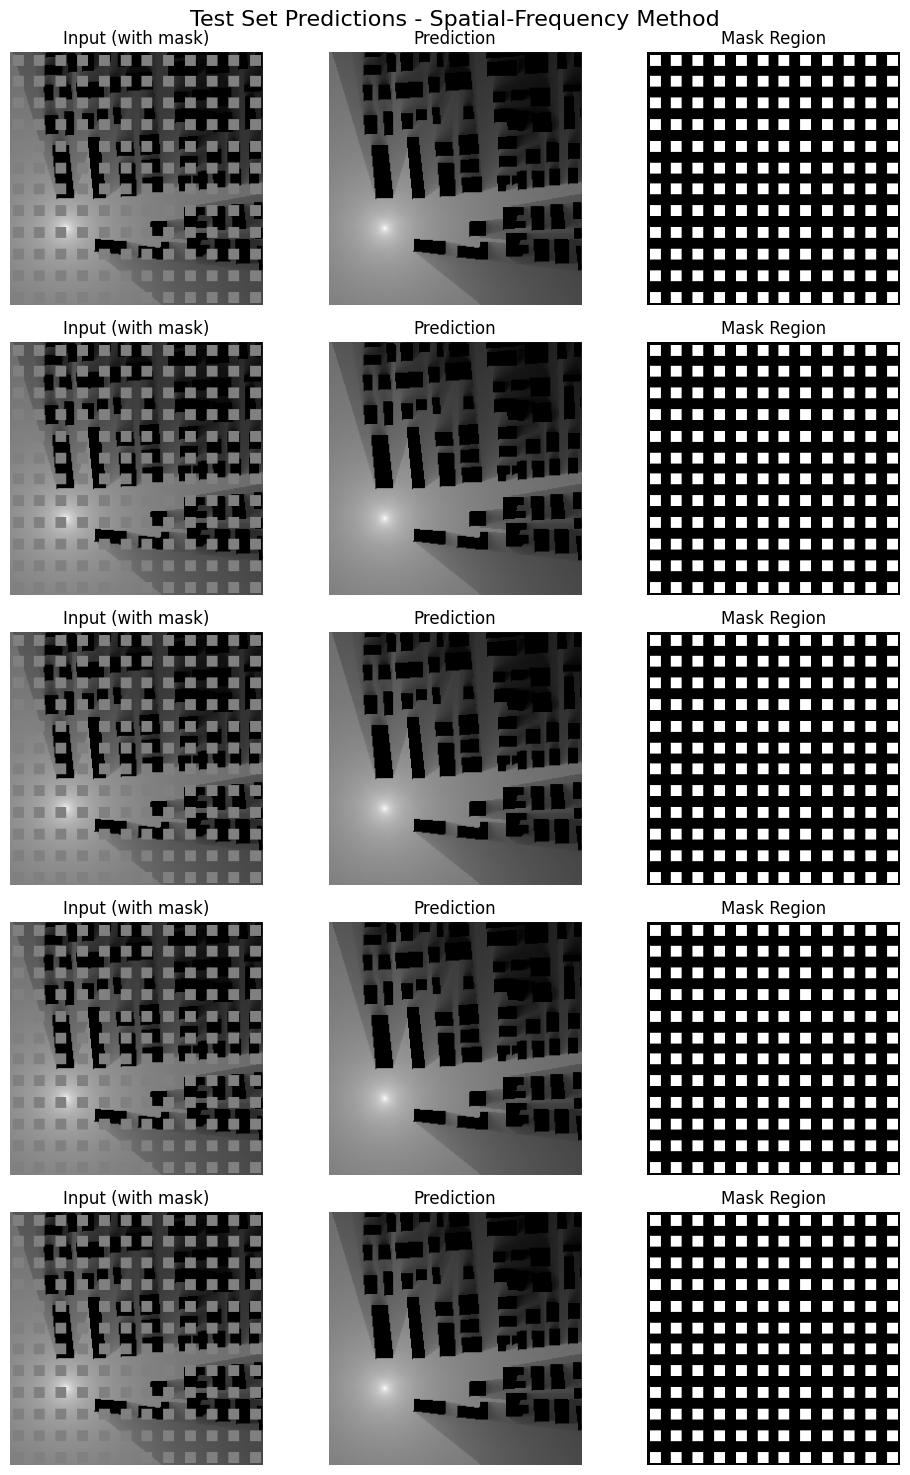

In [11]:
def visualize_test_results(test_loader, model, device, num_samples=6):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3*num_samples))
    
    indices = np.random.choice(len(test_loader), num_samples, replace=False)
    
    with torch.no_grad():
        for idx, i in enumerate(indices):
            batch = next(iter(test_loader))
            
            input_img = batch['input'].to(device)
            original_img = batch['original'].to(device)
            mask = batch['mask'].to(device)
            
            model_input = torch.cat([input_img, mask], dim=1)
            
            output = model(model_input, mask)
            
            final_output = original_img * mask + output * (1 - mask)
            
            input_np = input_img[0, 0].cpu().numpy()
            output_np = final_output[0, 0].cpu().numpy()
            mask_np = mask[0, 0].cpu().numpy()
            
            axes[idx, 0].imshow(input_np, cmap='gray', vmin=0, vmax=1)
            axes[idx, 0].set_title('Input (with mask)')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(output_np, cmap='gray', vmin=0, vmax=1)
            axes[idx, 1].set_title('Prediction')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(1-mask_np, cmap='gray', vmin=0, vmax=1)
            axes[idx, 2].set_title('Mask Region')
            axes[idx, 2].axis('off')
    
    plt.suptitle('Test Set Predictions - Spatial-Frequency Method', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'test_predictions.png'), dpi=300)
    plt.show()

visualize_test_results(test_loader, model, device, num_samples=5)

## 12. 方法总结

In [12]:
print("="*70)
print("Radio Map补全任务 - 空间频域混合方法总结")
print("="*70)
print(f"\n方法特点:")
print(f"  1. 空间上下文感知: 多尺度卷积捕获不同范围的信号传播模式")
print(f"  2. 频域分析: 通过FFT分析频域特征，适合处理周期性信号")
print(f"  3. 渐进式修复: 从粗粒度到细粒度逐步完善预测")
print(f"  4. 物理约束: 考虑信号传播的距离衰减和平滑性")
print(f"\n创新点:")
print(f"  - 结合空间域和频域的优势")
print(f"  - 多尺度渐进式处理策略")
print(f"  - 物理约束确保结果合理性")
print(f"  - 自适应特征融合机制")
print(f"\n训练配置:")
print(f"  总训练轮数: {config.epochs}")
print(f"  批量大小: {config.batch_size}")
print(f"  基础通道数: {config.base_channels}")
print(f"  最佳验证NMSE: {best_val_nmse:.4g} (Epoch {best_epoch})")
print(f"\n模型规模:")
print(f"  参数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"  训练数据: {len(train_dataset)} 张")
print(f"  验证数据: {len(val_dataset)} 张")
print(f"  测试数据: {len(test_dataset)} 张")
print(f"\n输出路径: {OUTPUT_PATH}")
print(f"模型路径: {MODEL_PATH}")
print("="*70)

Radio Map补全任务 - 空间频域混合方法总结

方法特点:
  1. 空间上下文感知: 多尺度卷积捕获不同范围的信号传播模式
  2. 频域分析: 通过FFT分析频域特征，适合处理周期性信号
  3. 渐进式修复: 从粗粒度到细粒度逐步完善预测
  4. 物理约束: 考虑信号传播的距离衰减和平滑性

创新点:
  - 结合空间域和频域的优势
  - 多尺度渐进式处理策略
  - 物理约束确保结果合理性
  - 自适应特征融合机制

训练配置:
  总训练轮数: 50
  批量大小: 24
  基础通道数: 64
  最佳验证NMSE: 0.0004538 (Epoch 28)

模型规模:
  参数量: 15,043,442
  训练数据: 44163 张
  验证数据: 4907 张
  测试数据: 7010 张

输出路径: output_spatial_frequency
模型路径: models_spatial_frequency
